In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

C:\Users\Nylle\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Nylle\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Nylle\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# READ IN ALL DATA
comments = pd.read_csv('comments_preprocessed_assigned.csv')
sentiment = pd.read_csv('df_pred_id_body.csv')
fin_data = pd.read_csv(r'C:\Users\Nylle\`Assignments\LSTM\Stock\AMC_2021.csv')

In [3]:
import prediction_prep as prep

df = prep.get_regression_df(ticker_name = 'amc', #
                           comments = comments, 
                           fin_data = fin_data,
                           sentiment = sentiment)
df.head()

,date,comments_neutral,comments_positive,comment_count,pct_pos_comments,is_meme,comments_neutral_rollsum_2D,comments_neutral_rollmean_2D,comments_neutral_2D_pctchg,comments_positive_rollsum_2D,...,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD,day_of_week,SD_log
0,2021-01-01,34.0,8.0,42.0,19.047574,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
1,2021-01-02,7.0,1.0,8.0,12.499844,0,41.0,20.5,NaN,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
2,2021-01-03,3.0,1.0,4.0,24.999375,0,10.0,5.0,-91.176471,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
3,2021-01-04,0.0,0.0,0.0,0.000000,0,3.0,1.5,-100.000000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.788105,0,-0.238123
4,2021-01-05,0.0,0.0,0.0,0.000000,0,0.0,0.0,-100.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.815720,1,-0.203684


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 100 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           366 non-null    datetime64[ns]
 1   comments_neutral               366 non-null    float64       
 2   comments_positive              366 non-null    float64       
 3   comment_count                  366 non-null    float64       
 4   pct_pos_comments               366 non-null    float64       
 5   is_meme                        366 non-null    int32         
 6   comments_neutral_rollsum_2D    365 non-null    float64       
 7   comments_neutral_rollmean_2D   365 non-null    float64       
 8   comments_neutral_2D_pctchg     339 non-null    float64       
 9   comments_positive_rollsum_2D   365 non-null    float64       
 10  comments_positive_rollmean_2D  365 non-null    float64       
 11  comments_positive_

## LSTM: AMC Close Price

### Without Normalization

In [5]:
## DAILY%CHANGE ##
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['6D%Change', '5Dir', 'Low', 'SD_log', '7Dir', 'Daily%Change', '2Dir', '4D%Change', 'Open', '3D%Change', 'Dir', '7D%Change', 'SD', '6Dir', 'High', '3Dir', 'Volume', '5D%Change', '4Dir', '2D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,7D%Change(t-1),SD(t-1),6Dir(t-1),High(t-1),3Dir(t-1),Volume(t-1),5D%Change(t-1),4Dir(t-1),2D%Change(t-1),Close(t-1)
10,3.06,1,101.0,51.0,152.0,33.552610,101.0,50.5,100.000000,51.0,...,15.920395,3.761593,1.0,2.55,1.0,162356400.0,8.878496,1.0,6.880727,2.33
11,2.97,2,76.0,26.0,102.0,25.490171,177.0,88.5,100.000000,77.0,...,49.268293,6.979592,1.0,3.20,1.0,256276000.0,39.090903,1.0,40.366966,3.06
12,2.98,3,45.0,28.0,73.0,38.356112,121.0,60.5,-55.445545,54.0,...,38.785041,3.144200,1.0,3.34,1.0,181862200.0,29.694327,1.0,27.467817,2.97
13,3.51,4,8.0,7.0,15.0,46.666356,53.0,26.5,-89.473684,35.0,...,35.454543,1.222619,1.0,3.06,1.0,64823800.0,36.697244,1.0,-2.614377,2.98
14,4.42,0,6.0,3.0,9.0,33.332963,19.0,9.5,-40.000000,9.0,...,53.275111,7.304642,1.0,3.74,1.0,268273400.0,61.009169,1.0,18.181817,3.51


In [6]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-1)', 'comments_positive(t-1)', 'comment_count(t-1)', 'pct_pos_comments(t-1)', 'comments_neutral_rollsum_2D(t-1)', 'comments_neutral_rollmean_2D(t-1)', 'comments_neutral_2D_pctchg(t-1)', 'comments_positive_rollsum_2D(t-1)', 'comments_positive_rollmean_2D(t-1)', 'comments_positive_2D_pctchg(t-1)', 'comment_count_rollsum_2D(t-1)', 'comment_count_rollmean_2D(t-1)', 'comment_count_2D_pctchg(t-1)', 'pct_pos_comments_rollsum_2D(t-1)', 'pct_pos_comments_rollmean_2D(t-1)', 'pct_pos_comments_2D_pctchg(t-1)', 'comments_neutral_rollsum_3D(t-1)', 'comments_neutral_rollmean_3D(t-1)', 'comments_neutral_3D_pctchg(t-1)', 'comments_positive_rollsum_3D(t-1)', 'comments_positive_rollmean_3D(t-1)', 'comments_positive_3D_pctchg(t-1)', 'comment_count_rollsum_3D(t-1)', 'comment_count_rollmean_3D(t-1)', 'comment_count_3D_pctchg(t-1)', 'pct_pos_comments_rollsum_3D(t-1)', 'pct_pos_comments_rollmean_3D(t-1)', 'pct_pos_comments_3D_pctchg(t-1)', 'comments_ne

,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,SD(t-1),6Dir(t-1),High(t-1),3Dir(t-1),Volume(t-1),5D%Change(t-1),4Dir(t-1),2D%Change(t-1),Close(t-1),Prediction
231,30.280001,3,3.0,3.0,6.0,49.999167,3.0,1.5,-25.000000,3.0,...,3.612228,0.0,34.939999,0.0,63296100.0,-27.042901,0.0,-22.448427,28.570000,30.280001
233,28.790001,0,24.0,8.0,32.0,24.999922,226.0,113.0,100.000000,33.0,...,3.960400,0.0,31.059999,0.0,66188600.0,-22.907256,0.0,1.540079,29.010000,28.790001
235,32.349998,2,1.0,1.0,2.0,49.997500,7.0,3.5,-95.833333,1.0,...,2.643753,0.0,31.680000,1.0,47927100.0,-8.544484,1.0,6.997589,31.040001,32.349998
237,27.440001,4,370.0,114.0,484.0,23.553714,371.0,185.5,36900.000000,114.0,...,1.203369,1.0,32.950001,1.0,36556800.0,-2.708063,1.0,-5.090212,29.459999,27.440001
245,28.680000,2,3.0,2.0,5.0,39.999200,3.0,1.5,100.000000,2.0,...,2.143640,1.0,32.230000,1.0,46852500.0,23.673466,1.0,4.052192,30.299999,28.680000


In [7]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(165, 100)
(48, 100)


In [8]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(158, 7, 100) (158,)
(41, 7, 100) (41,)
0.09499832428711952
0.09499832428711952


In [9]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'AMC_Sentiment_ClosePrice_woNormalization.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.7580
Epoch 1: val_loss improved from inf to 0.01310, saving model to AMC_Sentiment_ClosePrice_woNormalization.h5
10/10 [==============================] - 6s 255ms/step - loss: 0.7580 - val_loss: 0.0131
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0497
Epoch 2: val_loss improved from 0.01310 to 0.01278, saving model to AMC_Sentiment_ClosePrice_woNormalization.h5
10/10 [==============================] - 2s 159ms/step - loss: 0.0497 - val_loss: 0.0128
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0273
Epoch 3: val_loss did not improve from 0.01278
10/10 [==============================] - 2s 161ms/step - loss: 0.0273 - val_loss: 0.0209
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0118
Epoch 4: val_loss improved from 0.01278 to 0.00438, saving model to AMC_Sentiment_ClosePrice_woNormalization.h5
10/10 [==============================] - 2s 183ms/

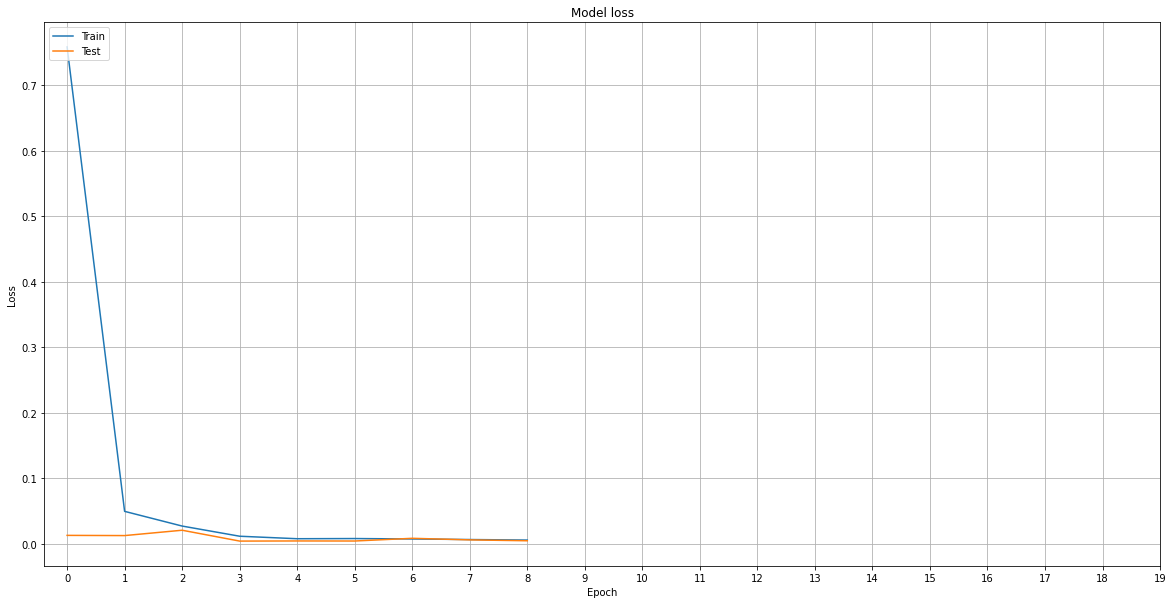

In [11]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 3.23
Mean Absolute Percentage Error (MAPE): 9.03 %
Median Absolute Percentage Error (MDAPE): 6.85 %


,MAE,MAPE,MDAPE
0,3.234976,9.028533,6.854004


In [13]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

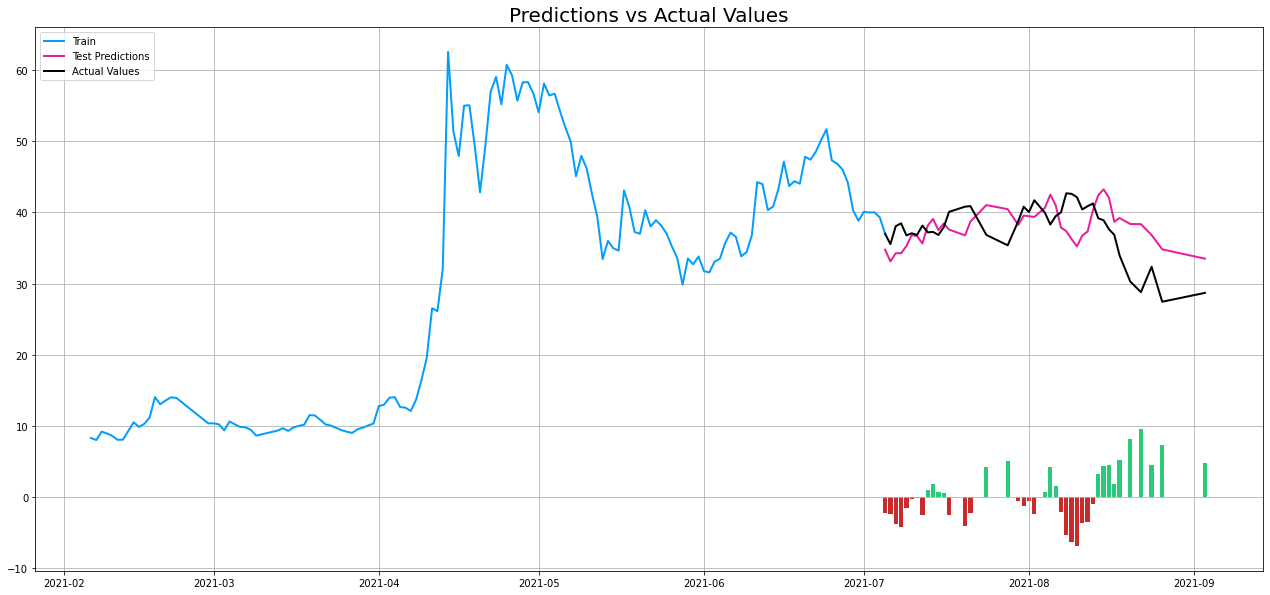

In [14]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Normalization

In [15]:
## DAILY%CHANGE ##
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['6D%Change', '5Dir', 'Low', 'SD_log', '7Dir', 'Daily%Change', '2Dir', '4D%Change', 'Open', '3D%Change', 'Dir', '7D%Change', 'SD', '6Dir', 'High', '3Dir', 'Volume', '5D%Change', '4Dir', '2D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,7D%Change(t-1),SD(t-1),6Dir(t-1),High(t-1),3Dir(t-1),Volume(t-1),5D%Change(t-1),4Dir(t-1),2D%Change(t-1),Close(t-1)
10,3.06,1,101.0,51.0,152.0,33.552610,101.0,50.5,100.000000,51.0,...,15.920395,3.761593,1.0,2.55,1.0,162356400.0,8.878496,1.0,6.880727,2.33
11,2.97,2,76.0,26.0,102.0,25.490171,177.0,88.5,100.000000,77.0,...,49.268293,6.979592,1.0,3.20,1.0,256276000.0,39.090903,1.0,40.366966,3.06
12,2.98,3,45.0,28.0,73.0,38.356112,121.0,60.5,-55.445545,54.0,...,38.785041,3.144200,1.0,3.34,1.0,181862200.0,29.694327,1.0,27.467817,2.97
13,3.51,4,8.0,7.0,15.0,46.666356,53.0,26.5,-89.473684,35.0,...,35.454543,1.222619,1.0,3.06,1.0,64823800.0,36.697244,1.0,-2.614377,2.98
14,4.42,0,6.0,3.0,9.0,33.332963,19.0,9.5,-40.000000,9.0,...,53.275111,7.304642,1.0,3.74,1.0,268273400.0,61.009169,1.0,18.181817,3.51


In [16]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'comments_neutral(t-1)', 'comments_positive(t-1)', 'comment_count(t-1)', 'pct_pos_comments(t-1)', 'comments_neutral_rollsum_2D(t-1)', 'comments_neutral_rollmean_2D(t-1)', 'comments_neutral_2D_pctchg(t-1)', 'comments_positive_rollsum_2D(t-1)', 'comments_positive_rollmean_2D(t-1)', 'comments_positive_2D_pctchg(t-1)', 'comment_count_rollsum_2D(t-1)', 'comment_count_rollmean_2D(t-1)', 'comment_count_2D_pctchg(t-1)', 'pct_pos_comments_rollsum_2D(t-1)', 'pct_pos_comments_rollmean_2D(t-1)', 'pct_pos_comments_2D_pctchg(t-1)', 'comments_neutral_rollsum_3D(t-1)', 'comments_neutral_rollmean_3D(t-1)', 'comments_neutral_3D_pctchg(t-1)', 'comments_positive_rollsum_3D(t-1)', 'comments_positive_rollmean_3D(t-1)', 'comments_positive_3D_pctchg(t-1)', 'comment_count_rollsum_3D(t-1)', 'comment_count_rollmean_3D(t-1)', 'comment_count_3D_pctchg(t-1)', 'pct_pos_comments_rollsum_3D(t-1)', 'pct_pos_comments_rollmean_3D(t-1)', 'pct_pos_comments_3D_pctchg(t-1)', 'comments_ne

,Close,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,SD(t-1),6Dir(t-1),High(t-1),3Dir(t-1),Volume(t-1),5D%Change(t-1),4Dir(t-1),2D%Change(t-1),Close(t-1),Prediction
231,30.280001,3,3.0,3.0,6.0,49.999167,3.0,1.5,-25.000000,3.0,...,3.612228,0.0,34.939999,0.0,63296100.0,-27.042901,0.0,-22.448427,28.570000,30.280001
233,28.790001,0,24.0,8.0,32.0,24.999922,226.0,113.0,100.000000,33.0,...,3.960400,0.0,31.059999,0.0,66188600.0,-22.907256,0.0,1.540079,29.010000,28.790001
235,32.349998,2,1.0,1.0,2.0,49.997500,7.0,3.5,-95.833333,1.0,...,2.643753,0.0,31.680000,1.0,47927100.0,-8.544484,1.0,6.997589,31.040001,32.349998
237,27.440001,4,370.0,114.0,484.0,23.553714,371.0,185.5,36900.000000,114.0,...,1.203369,1.0,32.950001,1.0,36556800.0,-2.708063,1.0,-5.090212,29.459999,27.440001
245,28.680000,2,3.0,2.0,5.0,39.999200,3.0,1.5,100.000000,2.0,...,2.143640,1.0,32.230000,1.0,46852500.0,23.673466,1.0,4.052192,30.299999,28.680000


In [17]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)


# # Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# # Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)


# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)


(165, 100)
(48, 100)


In [18]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(158, 7, 100) (158,)
(41, 7, 100) (41,)
0.09499832428711952
0.09499832428711952


In [19]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'AMC_Sentiment_ClosePrice_Normalized.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.4807
Epoch 1: val_loss improved from inf to 0.01107, saving model to AMC_Sentiment_ClosePrice_Normalized.h5
10/10 [==============================] - 6s 248ms/step - loss: 0.4807 - val_loss: 0.0111
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0412
Epoch 2: val_loss did not improve from 0.01107
10/10 [==============================] - 1s 147ms/step - loss: 0.0412 - val_loss: 0.0573
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0284
Epoch 3: val_loss did not improve from 0.01107
10/10 [==============================] - 2s 160ms/step - loss: 0.0284 - val_loss: 0.0138
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0159
Epoch 4: val_loss did not improve from 0.01107
10/10 [==============================] - 2s 159ms/step - loss: 0.0159 - val_loss: 0.0123
Epoch 5/100
10/10 [==============================] - ETA: 0s - loss: 0.0127
Epoch 5: val_loss di

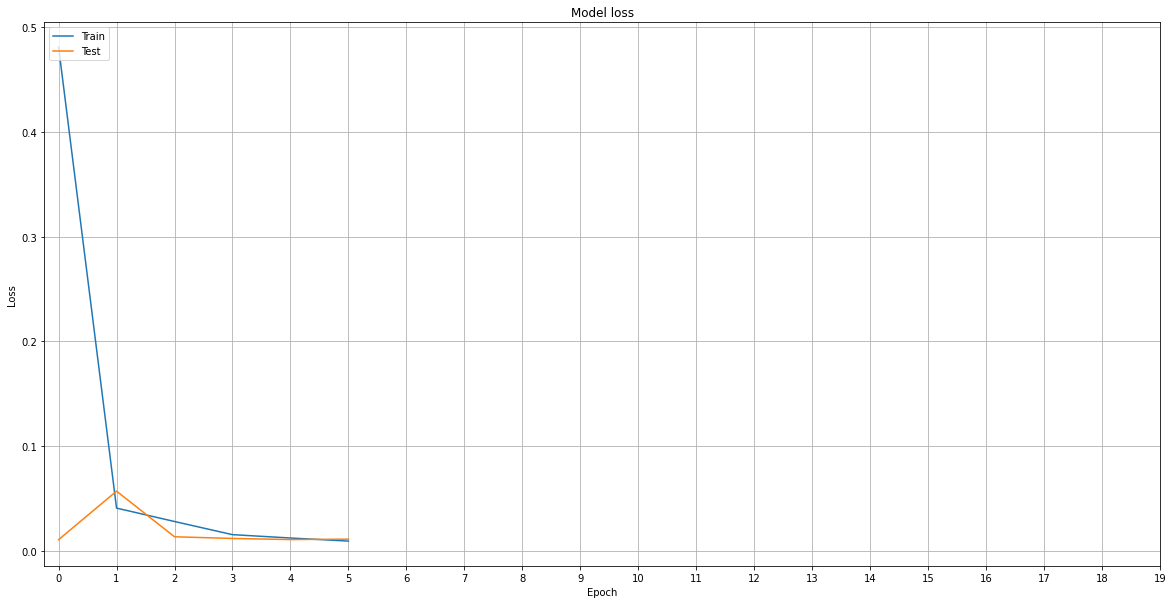

In [21]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]

# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)


    # Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred = standard_scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled = standard_scaler_pred.inverse_transform(y_test_unscaled)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 5.06
Mean Absolute Percentage Error (MAPE): 14.13 %
Median Absolute Percentage Error (MDAPE): 14.48 %


,MAE,MAPE,MDAPE
0,5.064488,14.126489,14.478243


In [23]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# # Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

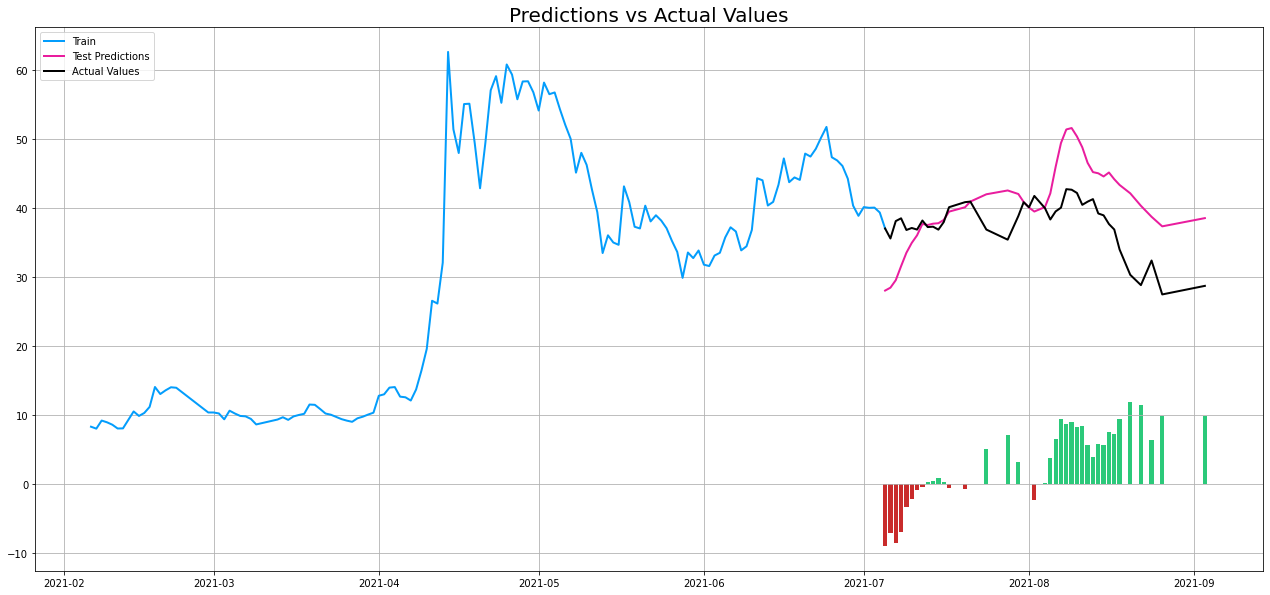

In [24]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## LSTM: AMC Daily%Change

### Without Normalization

In [25]:
## DAILY%CHANGE ##
dep_var = ['Daily%Change'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['6D%Change', '5Dir', 'Low', 'SD_log', '7Dir', '2Dir', '4D%Change', 'Open', '3D%Change', 'Dir', '7D%Change', 'SD', 'Close', '6Dir', 'High', '3Dir', 'Volume', '5D%Change', '4Dir', '2D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Daily%Change,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,SD(t-1),Close(t-1),6Dir(t-1),High(t-1),3Dir(t-1),Volume(t-1),5D%Change(t-1),4Dir(t-1),2D%Change(t-1),Daily%Change(t-1)
10,31.330474,1,101.0,51.0,152.0,33.552610,101.0,50.5,100.000000,51.0,...,3.761593,2.33,1.0,2.55,1.0,162356400.0,8.878496,1.0,6.880727,6.880727
11,-2.941174,2,76.0,26.0,102.0,25.490171,177.0,88.5,100.000000,77.0,...,6.979592,3.06,1.0,3.20,1.0,256276000.0,39.090903,1.0,40.366966,31.330474
12,0.336700,3,45.0,28.0,73.0,38.356112,121.0,60.5,-55.445545,54.0,...,3.144200,2.97,1.0,3.34,1.0,181862200.0,29.694327,1.0,27.467817,-2.941174
13,17.785234,4,8.0,7.0,15.0,46.666356,53.0,26.5,-89.473684,35.0,...,1.222619,2.98,1.0,3.06,1.0,64823800.0,36.697244,1.0,-2.614377,0.336700
14,25.925928,0,6.0,3.0,9.0,33.332963,19.0,9.5,-40.000000,9.0,...,7.304642,3.51,1.0,3.74,1.0,268273400.0,61.009169,1.0,18.181817,17.785234


In [26]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Daily%Change']

# Print the tail of the dataframe
data_filtered_ext.tail()

,Daily%Change,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,Close(t-1),6Dir(t-1),High(t-1),3Dir(t-1),Volume(t-1),5D%Change(t-1),4Dir(t-1),2D%Change(t-1),Daily%Change(t-1),Prediction
231,5.985303,3,3.0,3.0,6.0,49.999167,3.0,1.5,-25.000000,3.0,...,28.570000,0.0,34.939999,0.0,63296100.0,-27.042901,0.0,-22.448427,-15.822036,5.985303
233,-0.758357,0,24.0,8.0,32.0,24.999922,226.0,113.0,100.000000,33.0,...,29.010000,0.0,31.059999,0.0,66188600.0,-22.907256,0.0,1.540079,-4.194189,-0.758357
235,4.220353,2,1.0,1.0,2.0,49.997500,7.0,3.5,-95.833333,1.0,...,31.040001,0.0,31.680000,1.0,47927100.0,-8.544484,1.0,6.997589,7.815213,4.220353
237,-6.856750,4,370.0,114.0,484.0,23.553714,371.0,185.5,36900.000000,114.0,...,29.459999,1.0,32.950001,1.0,36556800.0,-2.708063,1.0,-5.090212,-8.933538,-6.856750
245,-5.346531,2,3.0,2.0,5.0,39.999200,3.0,1.5,100.000000,2.0,...,30.299999,1.0,32.230000,1.0,46852500.0,23.673466,1.0,4.052192,2.020197,-5.346531


In [27]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Daily%Change")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Daily%Change'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(165, 100)
(48, 100)


In [28]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(158, 7, 100) (158,)
(41, 7, 100) (41,)
0.0
0.0


In [29]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'AMC_Sentiment_DailyChange_woNormalization.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.1423
Epoch 1: val_loss improved from inf to 0.00393, saving model to AMC_Sentiment_DailyChange_woNormalization.h5
10/10 [==============================] - 5s 237ms/step - loss: 0.1423 - val_loss: 0.0039
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0055
Epoch 2: val_loss improved from 0.00393 to 0.00117, saving model to AMC_Sentiment_DailyChange_woNormalization.h5
10/10 [==============================] - 2s 167ms/step - loss: 0.0055 - val_loss: 0.0012
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0028
Epoch 3: val_loss did not improve from 0.00117
10/10 [==============================] - 2s 161ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0020
Epoch 4: val_loss did not improve from 0.00117
10/10 [==============================] - 1s 144ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 5/100
10/10 [=====

10/10 [==============================] - 2s 153ms/step - loss: 8.1440e-04 - val_loss: 5.5153e-04
Epoch 35/100
10/10 [==============================] - ETA: 0s - loss: 7.7931e-04
Epoch 35: val_loss did not improve from 0.00046
10/10 [==============================] - 1s 147ms/step - loss: 7.7931e-04 - val_loss: 4.8834e-04
Epoch 36/100
10/10 [==============================] - ETA: 0s - loss: 6.9564e-04
Epoch 36: val_loss did not improve from 0.00046
10/10 [==============================] - 1s 150ms/step - loss: 6.9564e-04 - val_loss: 5.3575e-04
Epoch 37/100
10/10 [==============================] - ETA: 0s - loss: 7.0888e-04
Epoch 37: val_loss did not improve from 0.00046
10/10 [==============================] - 1s 147ms/step - loss: 7.0888e-04 - val_loss: 6.3643e-04
Epoch 38/100
10/10 [==============================] - ETA: 0s - loss: 8.2124e-04
Epoch 38: val_loss did not improve from 0.00046
10/10 [==============================] - 2s 155ms/step - loss: 8.2124e-04 - val_loss: 8.7619e-04

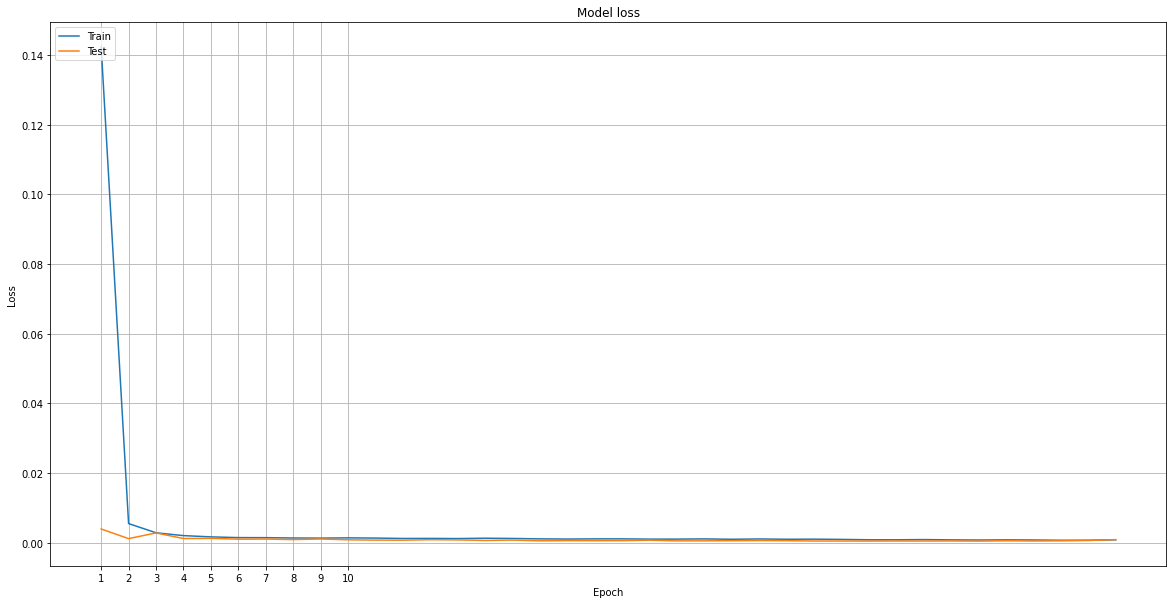

In [31]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 5.83
Mean Absolute Percentage Error (MAPE): 301.38 %
Median Absolute Percentage Error (MDAPE): 170.44 %


,MAE,MAPE,MDAPE
0,5.825741,301.378349,170.439036


In [33]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Daily%Change"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

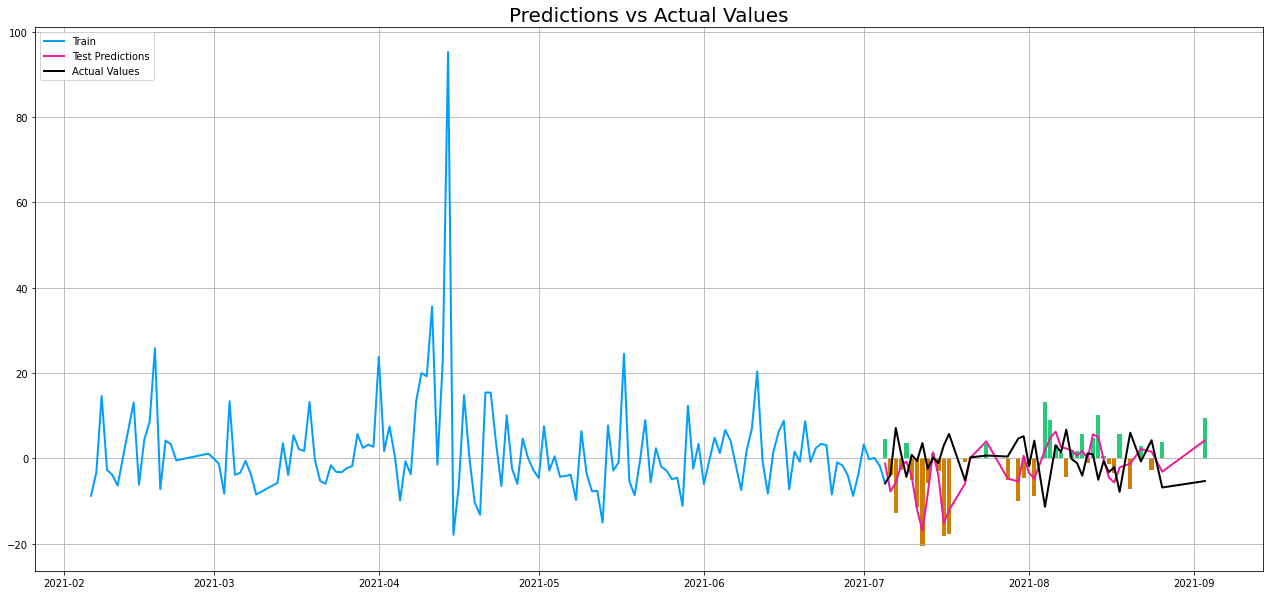

In [34]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Daily%Change"]]
xv = valid['Date']; yv = valid[["Daily%Change", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Daily%Change"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Normalization

In [35]:
## DAILY%CHANGE ##
dep_var = ['Daily%Change'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['6D%Change', '5Dir', 'Low', 'SD_log', '7Dir', '2Dir', '4D%Change', 'Open', '3D%Change', 'Dir', '7D%Change', 'SD', 'Close', '6Dir', 'High', '3Dir', 'Volume', '5D%Change', '4Dir', '2D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Daily%Change,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,SD(t-1),Close(t-1),6Dir(t-1),High(t-1),3Dir(t-1),Volume(t-1),5D%Change(t-1),4Dir(t-1),2D%Change(t-1),Daily%Change(t-1)
10,31.330474,1,101.0,51.0,152.0,33.552610,101.0,50.5,100.000000,51.0,...,3.761593,2.33,1.0,2.55,1.0,162356400.0,8.878496,1.0,6.880727,6.880727
11,-2.941174,2,76.0,26.0,102.0,25.490171,177.0,88.5,100.000000,77.0,...,6.979592,3.06,1.0,3.20,1.0,256276000.0,39.090903,1.0,40.366966,31.330474
12,0.336700,3,45.0,28.0,73.0,38.356112,121.0,60.5,-55.445545,54.0,...,3.144200,2.97,1.0,3.34,1.0,181862200.0,29.694327,1.0,27.467817,-2.941174
13,17.785234,4,8.0,7.0,15.0,46.666356,53.0,26.5,-89.473684,35.0,...,1.222619,2.98,1.0,3.06,1.0,64823800.0,36.697244,1.0,-2.614377,0.336700
14,25.925928,0,6.0,3.0,9.0,33.332963,19.0,9.5,-40.000000,9.0,...,7.304642,3.51,1.0,3.74,1.0,268273400.0,61.009169,1.0,18.181817,17.785234


In [36]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Daily%Change']

# Print the tail of the dataframe
data_filtered_ext.tail()

,Daily%Change,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,Close(t-1),6Dir(t-1),High(t-1),3Dir(t-1),Volume(t-1),5D%Change(t-1),4Dir(t-1),2D%Change(t-1),Daily%Change(t-1),Prediction
231,5.985303,3,3.0,3.0,6.0,49.999167,3.0,1.5,-25.000000,3.0,...,28.570000,0.0,34.939999,0.0,63296100.0,-27.042901,0.0,-22.448427,-15.822036,5.985303
233,-0.758357,0,24.0,8.0,32.0,24.999922,226.0,113.0,100.000000,33.0,...,29.010000,0.0,31.059999,0.0,66188600.0,-22.907256,0.0,1.540079,-4.194189,-0.758357
235,4.220353,2,1.0,1.0,2.0,49.997500,7.0,3.5,-95.833333,1.0,...,31.040001,0.0,31.680000,1.0,47927100.0,-8.544484,1.0,6.997589,7.815213,4.220353
237,-6.856750,4,370.0,114.0,484.0,23.553714,371.0,185.5,36900.000000,114.0,...,29.459999,1.0,32.950001,1.0,36556800.0,-2.708063,1.0,-5.090212,-8.933538,-6.856750
245,-5.346531,2,3.0,2.0,5.0,39.999200,3.0,1.5,100.000000,2.0,...,30.299999,1.0,32.230000,1.0,46852500.0,23.673466,1.0,4.052192,2.020197,-5.346531


In [37]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Daily%Change")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Daily%Change'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)


(165, 100)
(48, 100)


In [38]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(158, 7, 100) (158,)
(41, 7, 100) (41,)
0.0
0.0


In [39]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'AMC_Sentiment_DailyChange_Normalized.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.9161
Epoch 1: val_loss improved from inf to 0.01046, saving model to AMC_Sentiment_DailyChange_Normalized.h5
10/10 [==============================] - 5s 241ms/step - loss: 0.9161 - val_loss: 0.0105
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0279
Epoch 2: val_loss improved from 0.01046 to 0.00115, saving model to AMC_Sentiment_DailyChange_Normalized.h5
10/10 [==============================] - 2s 164ms/step - loss: 0.0279 - val_loss: 0.0011
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0090
Epoch 3: val_loss did not improve from 0.00115
10/10 [==============================] - 2s 152ms/step - loss: 0.0090 - val_loss: 0.0015
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0047
Epoch 4: val_loss did not improve from 0.00115
10/10 [==============================] - 1s 138ms/step - loss: 0.0047 - val_loss: 0.0022
Epoch 5/100
10/10 [===============

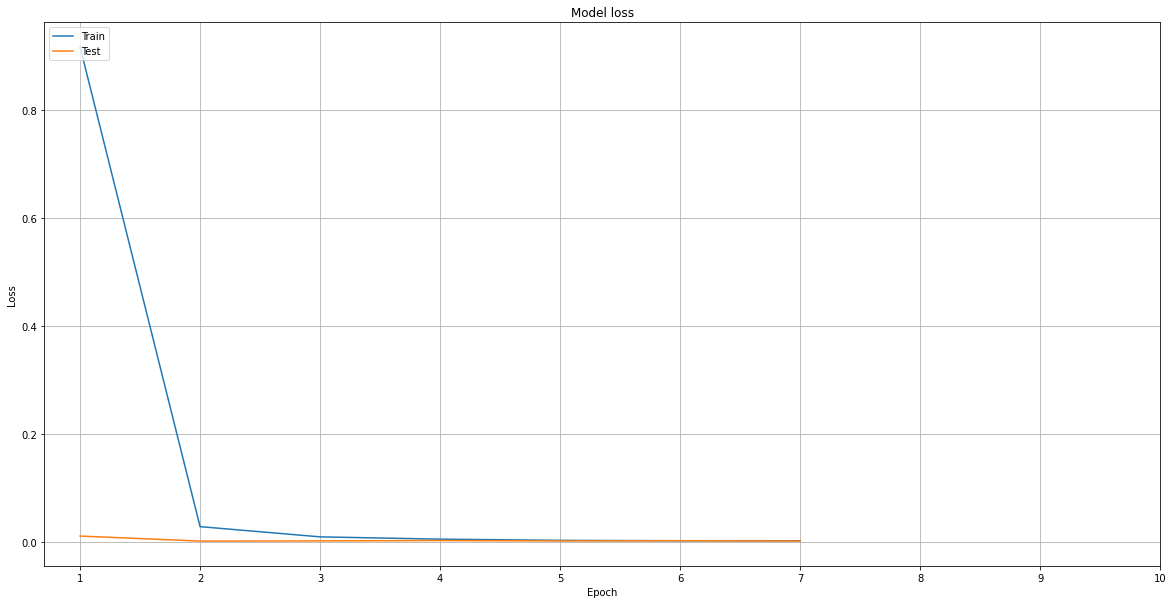

In [41]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [42]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred = standard_scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled = standard_scaler_pred.inverse_transform(y_test_unscaled)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 10.05
Mean Absolute Percentage Error (MAPE): 826.44 %
Median Absolute Percentage Error (MDAPE): 267.15 %


,MAE,MAPE,MDAPE
0,10.051833,826.435781,267.146882


In [43]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Daily%Change"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

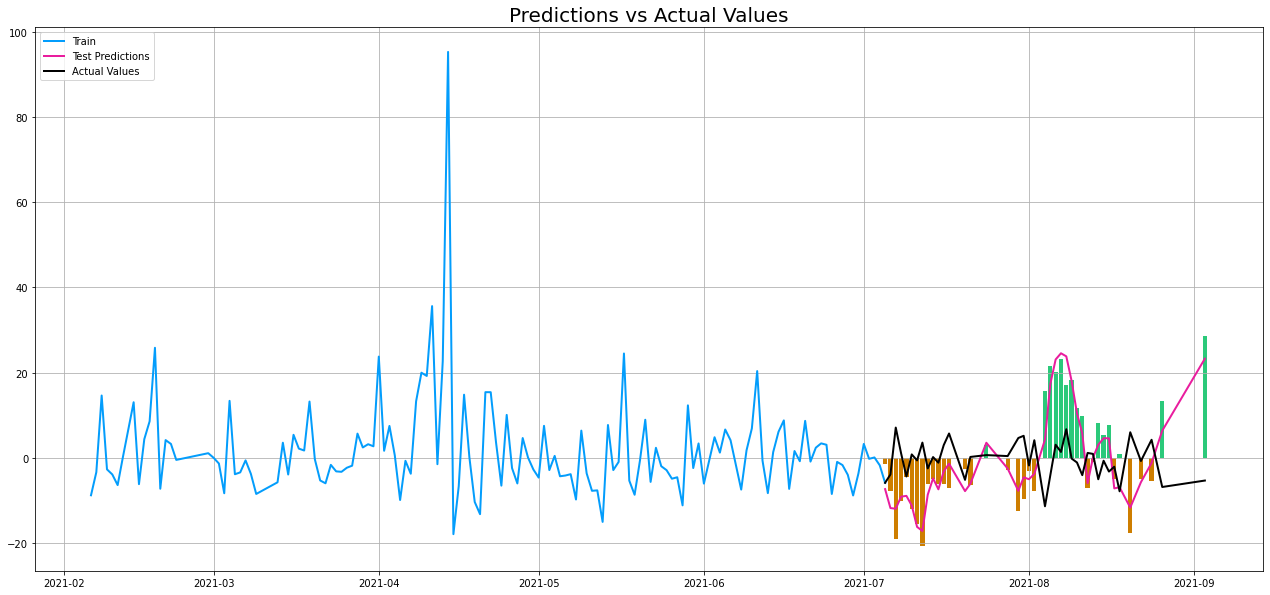

In [44]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Daily%Change"]]
xv = valid['Date']; yv = valid[["Daily%Change", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Daily%Change"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## LSTM: AMC SD

### Without Normalization

In [45]:
## DAILY%CHANGE ##
dep_var = ['SD'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['6D%Change', '5Dir', 'Low', 'SD_log', '7Dir', 'Daily%Change', '2Dir', '4D%Change', 'Open', '3D%Change', 'Dir', '7D%Change', 'Close', '6Dir', 'High', '3Dir', 'Volume', '5D%Change', '4Dir', '2D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,SD,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,7D%Change(t-1),Close(t-1),6Dir(t-1),High(t-1),3Dir(t-1),Volume(t-1),5D%Change(t-1),4Dir(t-1),2D%Change(t-1),SD(t-1)
10,6.979592,1,101.0,51.0,152.0,33.552610,101.0,50.5,100.000000,51.0,...,15.920395,2.33,1.0,2.55,1.0,162356400.0,8.878496,1.0,6.880727,3.761593
11,3.144200,2,76.0,26.0,102.0,25.490171,177.0,88.5,100.000000,77.0,...,49.268293,3.06,1.0,3.20,1.0,256276000.0,39.090903,1.0,40.366966,6.979592
12,1.222619,3,45.0,28.0,73.0,38.356112,121.0,60.5,-55.445545,54.0,...,38.785041,2.97,1.0,3.34,1.0,181862200.0,29.694327,1.0,27.467817,3.144200
13,7.304642,4,8.0,7.0,15.0,46.666356,53.0,26.5,-89.473684,35.0,...,35.454543,2.98,1.0,3.06,1.0,64823800.0,36.697244,1.0,-2.614377,1.222619
14,12.381951,0,6.0,3.0,9.0,33.332963,19.0,9.5,-40.000000,9.0,...,53.275111,3.51,1.0,3.74,1.0,268273400.0,61.009169,1.0,18.181817,7.304642


In [46]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['SD']

# Print the tail of the dataframe
data_filtered_ext.tail()

,SD,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,Close(t-1),6Dir(t-1),High(t-1),3Dir(t-1),Volume(t-1),5D%Change(t-1),4Dir(t-1),2D%Change(t-1),SD(t-1),Prediction
231,2.128260,3,3.0,3.0,6.0,49.999167,3.0,1.5,-25.000000,3.0,...,28.570000,0.0,34.939999,0.0,63296100.0,-27.042901,0.0,-22.448427,3.612228,2.128260
233,3.109342,0,24.0,8.0,32.0,24.999922,226.0,113.0,100.000000,33.0,...,29.010000,0.0,31.059999,0.0,66188600.0,-22.907256,0.0,1.540079,3.960400,3.109342
235,2.526468,2,1.0,1.0,2.0,49.997500,7.0,3.5,-95.833333,1.0,...,31.040001,0.0,31.680000,1.0,47927100.0,-8.544484,1.0,6.997589,2.643753,2.526468
237,3.948947,4,370.0,114.0,484.0,23.553714,371.0,185.5,36900.000000,114.0,...,29.459999,1.0,32.950001,1.0,36556800.0,-2.708063,1.0,-5.090212,1.203369,3.948947
245,1.787750,2,3.0,2.0,5.0,39.999200,3.0,1.5,100.000000,2.0,...,30.299999,1.0,32.230000,1.0,46852500.0,23.673466,1.0,4.052192,2.143640,1.787750


In [47]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("SD")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['SD'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(165, 100)
(48, 100)


In [48]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(158, 7, 100) (158,)
(41, 7, 100) (41,)
0.3406220354552558
0.3406220354552558


In [49]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'AMC_Sentiment_SD_woNormalization.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.3564
Epoch 1: val_loss improved from inf to 0.02300, saving model to AMC_Sentiment_SD_woNormalization.h5
10/10 [==============================] - 5s 252ms/step - loss: 0.3564 - val_loss: 0.0230
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0114
Epoch 2: val_loss improved from 0.02300 to 0.00113, saving model to AMC_Sentiment_SD_woNormalization.h5
10/10 [==============================] - 2s 169ms/step - loss: 0.0114 - val_loss: 0.0011
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0040
Epoch 3: val_loss did not improve from 0.00113
10/10 [==============================] - 2s 175ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0021
Epoch 4: val_loss improved from 0.00113 to 0.00083, saving model to AMC_Sentiment_SD_woNormalization.h5
10/10 [==============================] - 2s 183ms/step - loss: 0.0021 - va

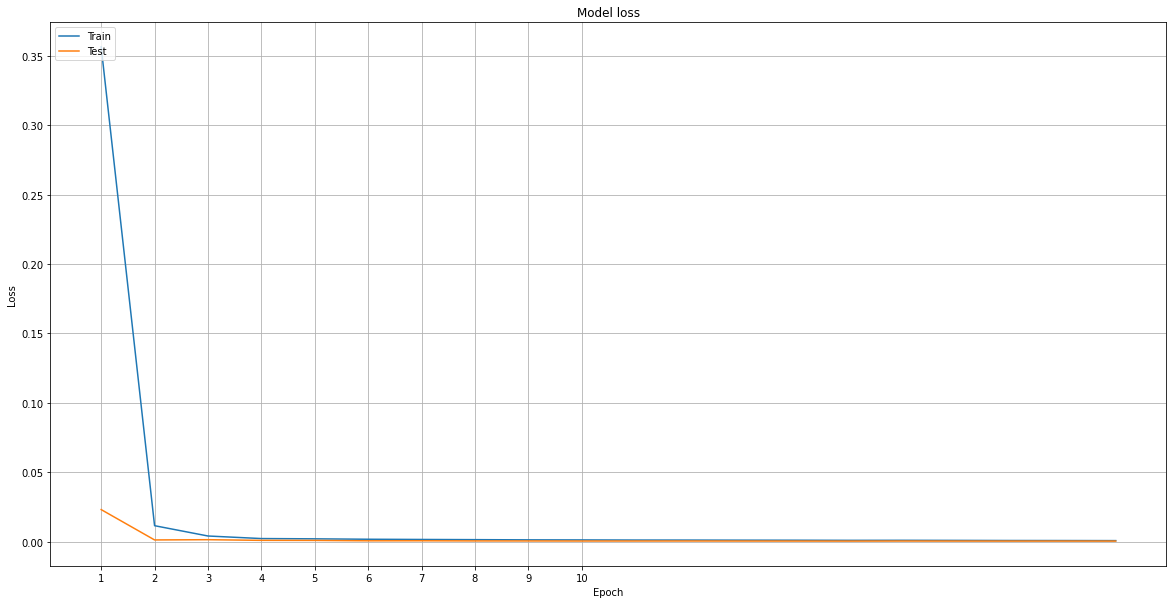

In [51]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [52]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 1.23
Mean Absolute Percentage Error (MAPE): 101.79 %
Median Absolute Percentage Error (MDAPE): 66.68 %


,MAE,MAPE,MDAPE
0,1.231617,101.787559,66.678332


In [53]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["SD"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

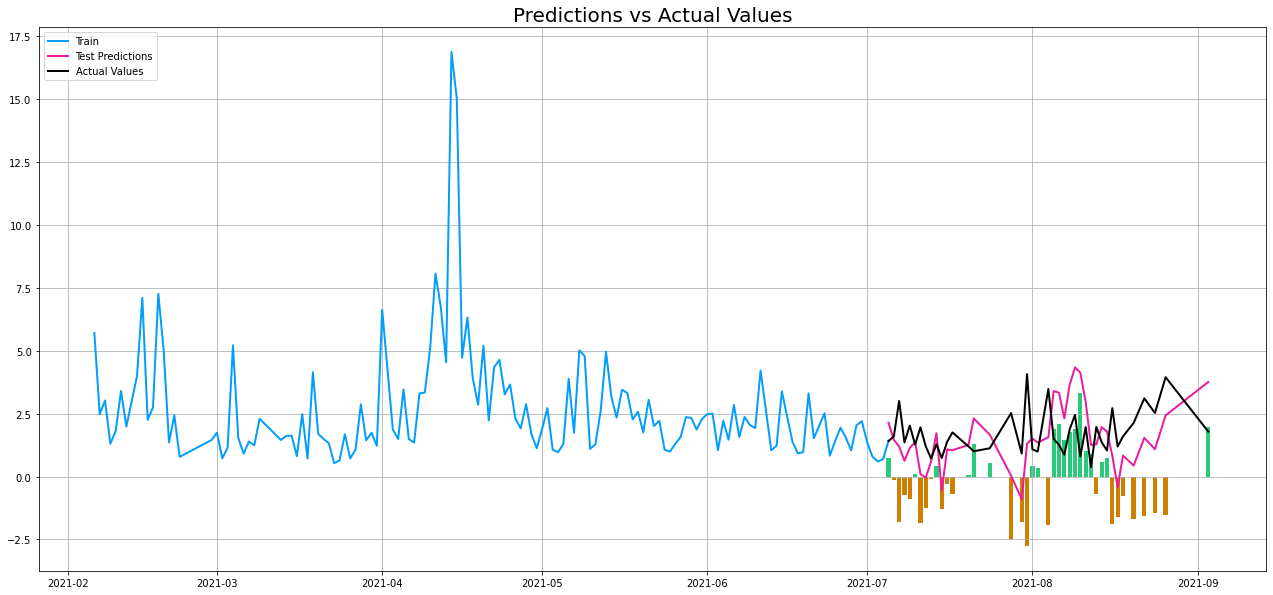

In [54]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["SD"]]
xv = valid['Date']; yv = valid[["SD", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["SD"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Normalization

In [55]:
## DAILY%CHANGE ##
dep_var = ['SD'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)

pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['6D%Change', '5Dir', 'Low', 'SD_log', '7Dir', 'Daily%Change', '2Dir', '4D%Change', 'Open', '3D%Change', 'Dir', '7D%Change', 'Close', '6Dir', 'High', '3Dir', 'Volume', '5D%Change', '4Dir', '2D%Change']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,SD,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,7D%Change(t-1),Close(t-1),6Dir(t-1),High(t-1),3Dir(t-1),Volume(t-1),5D%Change(t-1),4Dir(t-1),2D%Change(t-1),SD(t-1)
10,6.979592,1,101.0,51.0,152.0,33.552610,101.0,50.5,100.000000,51.0,...,15.920395,2.33,1.0,2.55,1.0,162356400.0,8.878496,1.0,6.880727,3.761593
11,3.144200,2,76.0,26.0,102.0,25.490171,177.0,88.5,100.000000,77.0,...,49.268293,3.06,1.0,3.20,1.0,256276000.0,39.090903,1.0,40.366966,6.979592
12,1.222619,3,45.0,28.0,73.0,38.356112,121.0,60.5,-55.445545,54.0,...,38.785041,2.97,1.0,3.34,1.0,181862200.0,29.694327,1.0,27.467817,3.144200
13,7.304642,4,8.0,7.0,15.0,46.666356,53.0,26.5,-89.473684,35.0,...,35.454543,2.98,1.0,3.06,1.0,64823800.0,36.697244,1.0,-2.614377,1.222619
14,12.381951,0,6.0,3.0,9.0,33.332963,19.0,9.5,-40.000000,9.0,...,53.275111,3.51,1.0,3.74,1.0,268273400.0,61.009169,1.0,18.181817,7.304642


In [56]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['SD']

# Print the tail of the dataframe
data_filtered_ext.tail()

,SD,day_of_week,comments_neutral(t-1),comments_positive(t-1),comment_count(t-1),pct_pos_comments(t-1),comments_neutral_rollsum_2D(t-1),comments_neutral_rollmean_2D(t-1),comments_neutral_2D_pctchg(t-1),comments_positive_rollsum_2D(t-1),...,Close(t-1),6Dir(t-1),High(t-1),3Dir(t-1),Volume(t-1),5D%Change(t-1),4Dir(t-1),2D%Change(t-1),SD(t-1),Prediction
231,2.128260,3,3.0,3.0,6.0,49.999167,3.0,1.5,-25.000000,3.0,...,28.570000,0.0,34.939999,0.0,63296100.0,-27.042901,0.0,-22.448427,3.612228,2.128260
233,3.109342,0,24.0,8.0,32.0,24.999922,226.0,113.0,100.000000,33.0,...,29.010000,0.0,31.059999,0.0,66188600.0,-22.907256,0.0,1.540079,3.960400,3.109342
235,2.526468,2,1.0,1.0,2.0,49.997500,7.0,3.5,-95.833333,1.0,...,31.040001,0.0,31.680000,1.0,47927100.0,-8.544484,1.0,6.997589,2.643753,2.526468
237,3.948947,4,370.0,114.0,484.0,23.553714,371.0,185.5,36900.000000,114.0,...,29.459999,1.0,32.950001,1.0,36556800.0,-2.708063,1.0,-5.090212,1.203369,3.948947
245,1.787750,2,3.0,2.0,5.0,39.999200,3.0,1.5,100.000000,2.0,...,30.299999,1.0,32.230000,1.0,46852500.0,23.673466,1.0,4.052192,2.143640,1.787750


In [57]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("SD")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['SD'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)


(165, 100)
(48, 100)


In [58]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(158, 7, 100) (158,)
(41, 7, 100) (41,)
0.3406220354552558
0.3406220354552558


In [59]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

700 7 100


In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'AMC_Sentiment_SD_Normalized.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.1366
Epoch 1: val_loss improved from inf to 0.00945, saving model to AMC_Sentiment_SD_Normalized.h5
10/10 [==============================] - 5s 251ms/step - loss: 0.1366 - val_loss: 0.0095
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.0058
Epoch 2: val_loss improved from 0.00945 to 0.00040, saving model to AMC_Sentiment_SD_Normalized.h5
10/10 [==============================] - 2s 183ms/step - loss: 0.0058 - val_loss: 3.9619e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.0032
Epoch 3: val_loss did not improve from 0.00040
10/10 [==============================] - 2s 160ms/step - loss: 0.0032 - val_loss: 4.0422e-04
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.0021
Epoch 4: val_loss improved from 0.00040 to 0.00032, saving model to AMC_Sentiment_SD_Normalized.h5
10/10 [==============================] - 2s 162ms/step - loss: 0.0021 - val_loss:

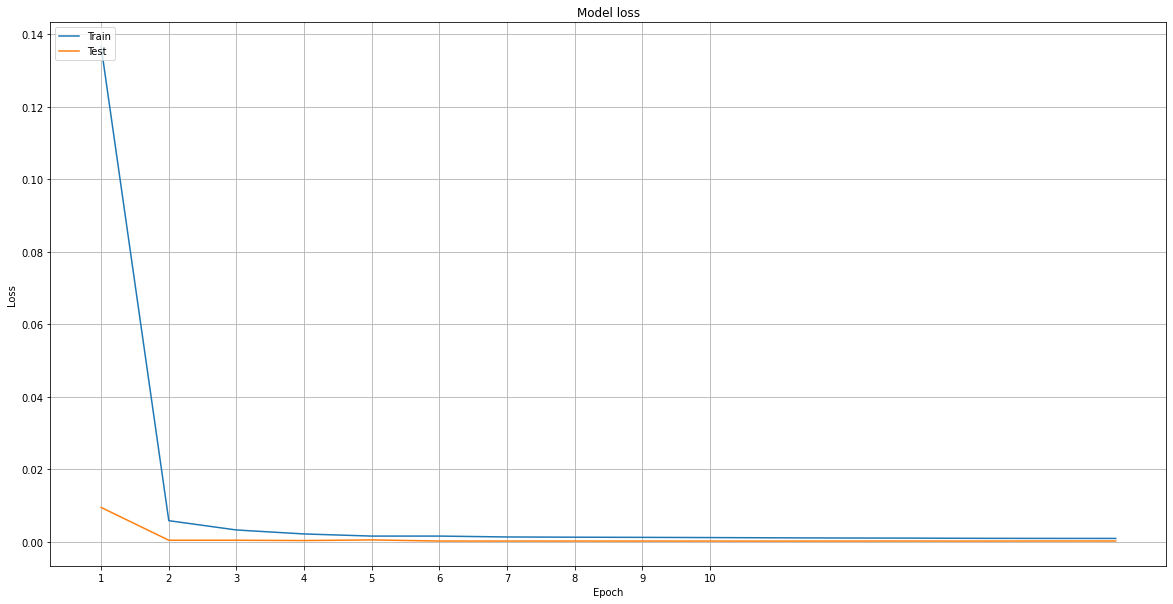

In [61]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [62]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred = standard_scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled = standard_scaler_pred.inverse_transform(y_test_unscaled)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.84
Mean Absolute Percentage Error (MAPE): 57.21 %
Median Absolute Percentage Error (MDAPE): 46.55 %


,MAE,MAPE,MDAPE
0,0.836425,57.209171,46.548972


In [63]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["SD"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

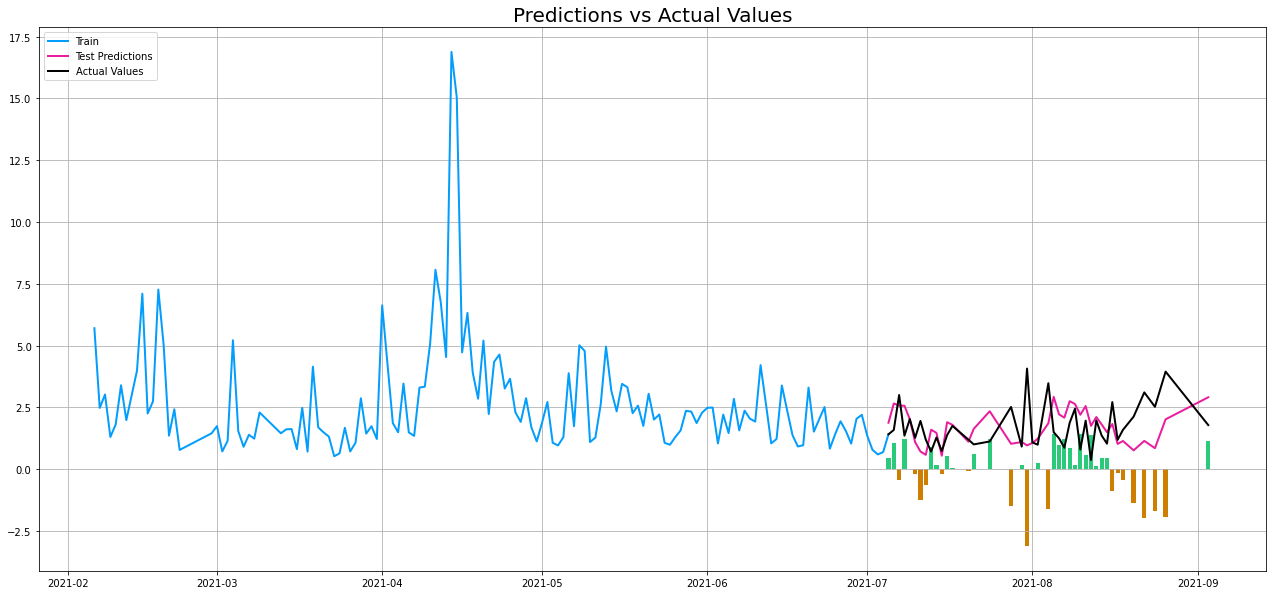

In [64]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["SD"]]
xv = valid['Date']; yv = valid[["SD", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["SD"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()